In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [4]:
import pickle

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [6]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [9]:
df=pd.read_csv('bank-additional-full.csv',sep=';')

## Exploratory Data Analysis

In [10]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [13]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Plot the distribution of each feature

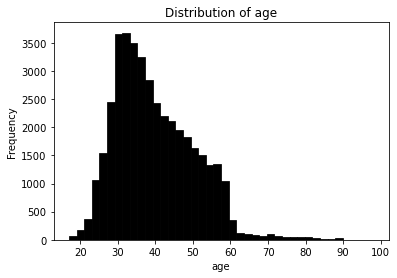

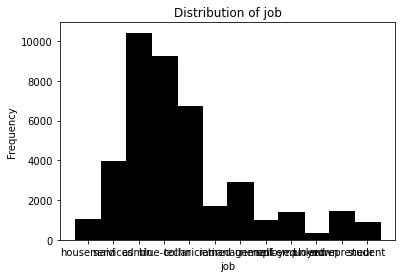

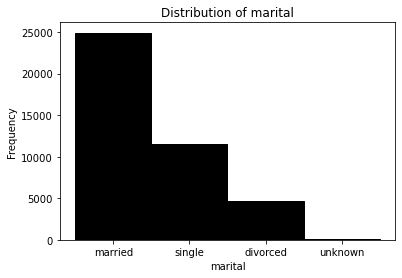

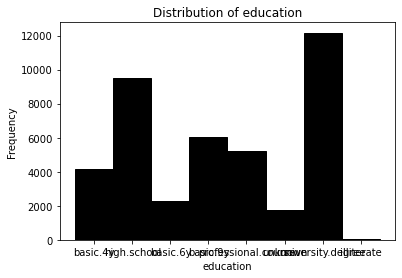

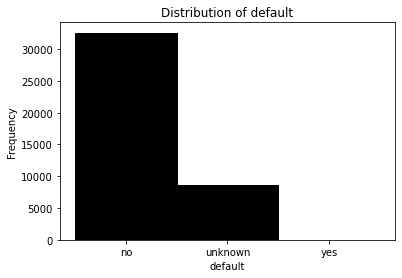

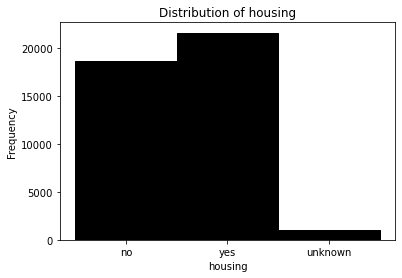

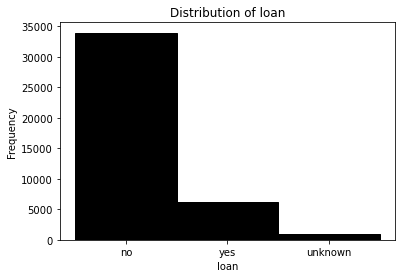

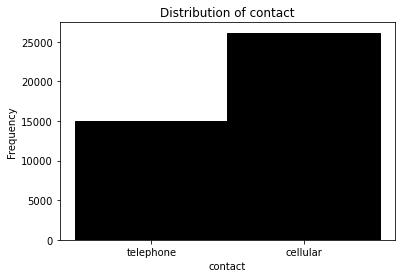

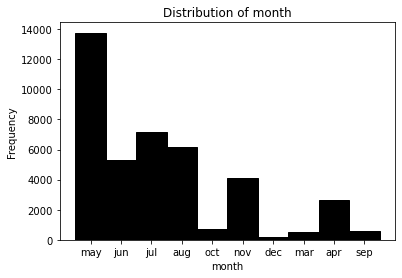

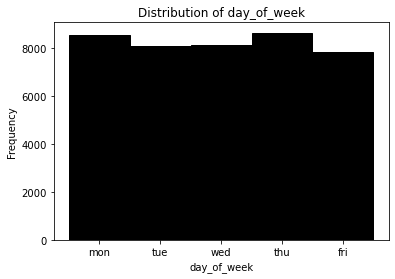

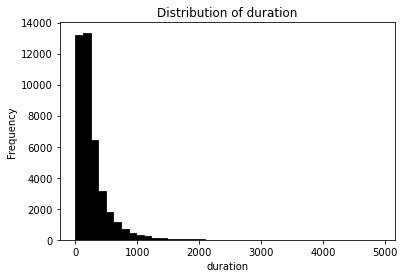

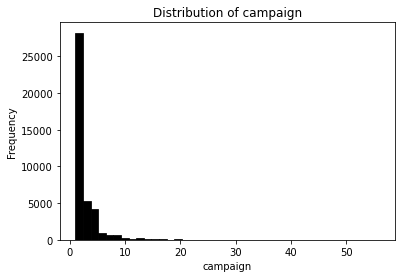

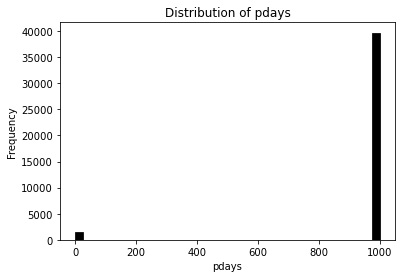

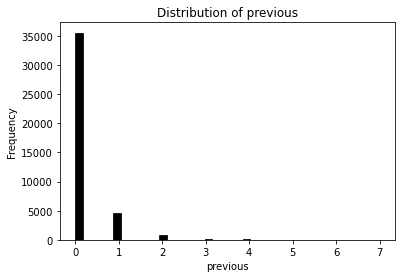

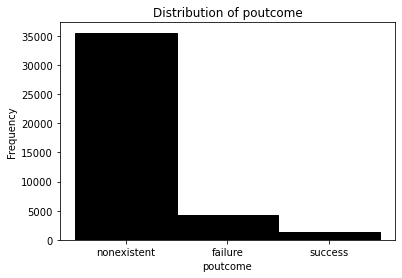

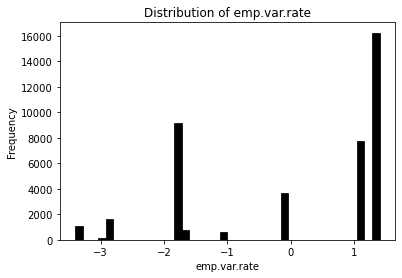

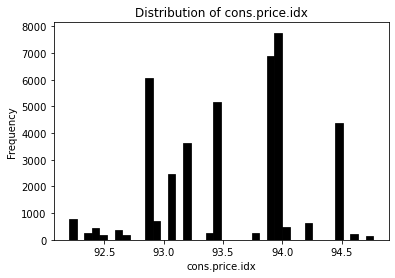

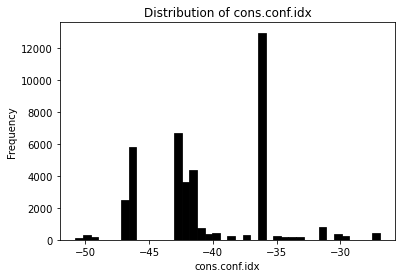

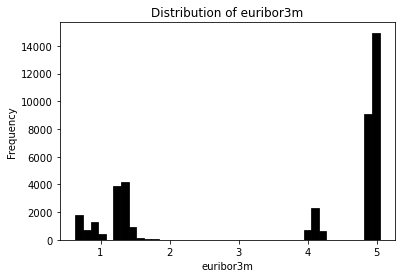

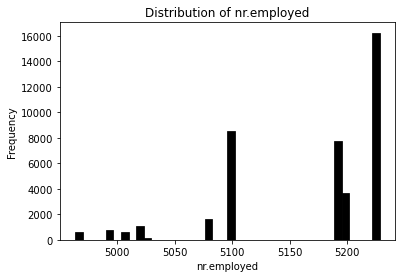

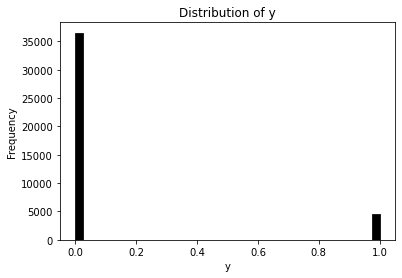

In [34]:
for c in df.columns:
    plt.figure(figsize=(6, 4))

    sns.histplot(df[c], bins=40, color='black', alpha=1)
    plt.ylabel('Frequency')
    plt.xlabel(c)
    plt.title('Distribution of '+c)

    plt.show()

In [14]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [17]:
df.y = (df.y == 'yes').astype(int)

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [19]:
numerical=['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
categorical=['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

## Logistic Regression

DictVectorizer to convert categorical data

In [20]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [21]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Cross validation

In [22]:
C = 1.0
n_splits = 5

In [23]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)


In [24]:
print('%.3f +- %.3f'%(np.mean(scores),np.std(scores)))

0.932 +- 0.003


In [25]:
dv, model = train(df_full_train, df_full_train.y.values, C=1.0)
y_pred = predict(df_test, dv, model)

y_test = df_test.y.values
auc = roc_auc_score(y_test, y_pred)
auc

0.9316332090922189

In [26]:
output_file=f'model_C={C}.bin'

In [27]:
f_out=open(output_file,'wb') #write, binary
pickle.dump((dv,model),f_out)
f_out.close()

## Load the model

In [52]:
with open(output_file,'rb') as f_in:
    dv,model=pickle.load(f_in)
    #auto closed the file

In [53]:
dv,model

(DictVectorizer(sparse=False), LogisticRegression(max_iter=1000))

In [78]:
np.set_printoptions(threshold=sys.maxsize)

In [83]:
set(df.marital.values)

{'divorced', 'married', 'single', 'unknown'}

In [84]:
customer={'age': 27,
 'job': 'student',
 'marital': 'single',
 'education': 'university.degree',
 'default': 'yes',
 'housing': 'no',
 'loan': 'no',
 'contact': 'cellular',
 'month': 'may',
 'day_of_week': 'mon',
 'duration': 55,
 'campaign': 3,
 'pdays': 999,
 'previous': 0,
 'poutcome': 'nonexistent',
 'emp.var.rate': 1.1,
 'cons.price.idx': 93.994,
 'cons.conf.idx': -36.4,
 'euribor3m': 4.857,
 'nr.employed': 5191.0,
 'y': 0}

In [85]:
X=dv.transform([customer])

In [86]:
model.predict_proba(X)[0,1]

0.006569082116736781

## Another model: Decision Tree

In [101]:
df_train.shape

(26360, 21)

In [102]:
df_val.shape

(6590, 21)

In [105]:
dict_train = df_train[categorical + numerical].to_dict(orient='records')
dict_val = df_val[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val=dv.transform(dict_val)

In [106]:
X_train.shape

(26360, 63)

In [107]:
X_val.shape

(6590, 63)

In [108]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [111]:
y_pred=dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7234557634557636

In [112]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc: %.3f' % auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

train auc: 0.856
val auc: 0.864


### Parameter tuning: max_depth

In [114]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.703
   2 -> 0.864
   3 -> 0.898
   4 -> 0.921
   5 -> 0.931
   6 -> 0.925
  10 -> 0.863
  15 -> 0.763
  20 -> 0.736
None -> 0.721


In [116]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.931
5 -> 0.929
10 -> 0.931
15 -> 0.930
20 -> 0.931
50 -> 0.926
100 -> 0.928
200 -> 0.929


In [118]:
for m in [1, 5, 10, 20]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()

depth: 1
1 -> 0.703
5 -> 0.703
10 -> 0.703
15 -> 0.703
20 -> 0.703
50 -> 0.703
100 -> 0.703
200 -> 0.703

depth: 5
1 -> 0.931
5 -> 0.929
10 -> 0.931
15 -> 0.930
20 -> 0.931
50 -> 0.926
100 -> 0.928
200 -> 0.929

depth: 10
1 -> 0.857
5 -> 0.887
10 -> 0.905
15 -> 0.920
20 -> 0.928
50 -> 0.940
100 -> 0.939
200 -> 0.941

depth: 20
1 -> 0.726
5 -> 0.839
10 -> 0.894
15 -> 0.911
20 -> 0.920
50 -> 0.935
100 -> 0.937
200 -> 0.939



### Parameter tuning: min_samples_leaf

In [119]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.931
5 -> 0.929
10 -> 0.931
15 -> 0.930
20 -> 0.931
50 -> 0.926
100 -> 0.928
200 -> 0.929


In [124]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.9309961884961886